# DSE 230: Programming Assignment 3 - Linear Regression

#### Tasks: 

- Linear Regression on the Boston Housing dataset.  
  
- Submission on Gradescope:
  - Submit this Jupyter Notebook as a PDF to "PA3 Notebook"
  - Convert this Notebook to a .py file and submit that to "PA3"

#### Due date: Friday 5/14/2021 at 11:59 PM PST

---

Remember: when in doubt, read the documentation first. It's always helpful to search for the class that you're trying to work with, e.g. pyspark.sql.DataFrame. 

PySpark API Documentation: https://spark.apache.org/docs/latest/api/python/index.html

Spark DataFrame Guide:  https://spark.apache.org/docs/latest/sql-programming-guide.html

Spark MLlib Guide: https://spark.apache.org/docs/latest/ml-guide.html

### Import libraries/functions

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np

### Initialize Spark
* Initialize Spark with 2 cores

In [2]:
conf = pyspark.SparkConf().setAll([('spark.master', 'local[2]'),
                                   ('spark.app.name', 'Python Spark SQL Demo')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

### Read the data from Boston_Housing.csv file
* Print the number of rows in the dataframe

In [3]:
# Create DataFrame based on contents of a JSON file
df = spark.read.csv("file:///home/work/Boston_Housing.csv", header = True, inferSchema = True)
print(df.count())

506


### Column names in file and their description

CRIM — per capita crime rate by town.

ZN — proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS — proportion of non-retail business acres per town.

CHAS — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

NOX — nitrogen oxides concentration (parts per 10 million).

RM — average number of rooms per dwelling.

AGE — proportion of owner-occupied units built prior to 1940.

DIS — weighted mean of distances to five Boston employment centres.

RAD — index of accessibility to radial highways.

TAX — full-value property-tax rate per $10,000.

PTRATIO — pupil-teacher ratio by town.

BLACK — 1000(Bk — 0.63)² where Bk is the proportion of blacks by town.

LSTAT — lower status of the population (percent).

MV — median value of owner-occupied homes in $1000s. This is the target variable.

### See one row of the dataframe

In [4]:
df.show(1)

+-------+----+-----+----+-----+-----+----+----+---+-----+-------+-----+-----+----+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE| DIS|RAD|  TAX|PTRATIO|BLACK|LSTAT|  MV|
+-------+----+-----+----+-----+-----+----+----+---+-----+-------+-----+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|4.09|  1|296.0|   15.3|396.9| 4.98|24.0|
+-------+----+-----+----+-----+-----+----+----+---+-----+-------+-----+-----+----+
only showing top 1 row



### Helper function for filling columns using mean or median strategy

In [5]:
from pyspark.ml.feature import Imputer

def fill_na(df, strategy):    
    imputer = Imputer(
        strategy=strategy,
        inputCols=df.columns, 
        outputCols=["{}_imputed".format(c) for c in df.columns]
    )
    
    new_df = imputer.fit(df).transform(df)
    
    # Select the newly created columns with all filled values
    new_df = new_df.select([c for c in new_df.columns if "imputed" in c])
    
    for col in new_df.columns:
        new_df = new_df.withColumnRenamed(col, col.split("_imputed")[0])
        
    return new_df

### Feature selection
* Print schema to verify

In [6]:
# These are the column names in the csv file as described above.
col_names = ['CRIM' , 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'BLACK', 'LSTAT', 'MV']

df.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: double (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- BLACK: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MV: double (nullable = true)



### Drop NA's in the target variable `MV`
* Print the number of remaining rows

In [7]:
df = df.dropna(subset = ['MV'])
print(df.count())

506


### Fill the NA's for remaining columns using a mean strategy
* Use the `fill_na` function provided above

In [8]:
fill_na(df, 'mean')

DataFrame[INDUS: double, NOX: double, AGE: double, CHAS: int, PTRATIO: double, CRIM: double, DIS: double, RAD: int, RM: double, ZN: double, TAX: double, MV: double, BLACK: double, LSTAT: double]

### Create feature vector using VectorAssembler

* Create a vector column composed of _all_ the features
* Don't include the label "MV" here since label isn't a feature

In [9]:
vectorAssembler = VectorAssembler(inputCols = ['CRIM' , 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'BLACK', 'LSTAT'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(df)
vhouse_df = vhouse_df.select(['features', 'MV'])
vhouse_df.show(2)

+--------------------+----+
|            features|  MV|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
+--------------------+----+
only showing top 2 rows



### Print first 5 rows of the created dataframe

In [10]:
print(vhouse_df.show(5))

+--------------------+----+
|            features|  MV|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows

None


### Rename the column `MV` to `Label`

In [11]:
vhouse_df = vhouse_df.withColumnRenamed('MV', 'Label')

### Split the dataframe using the randomSplit() function 
 * Train dataframe and test dataframe with a 75:25 split between them
 * Use seed=42 as one the parameters of the randomSplit() function to maintain consistency among all submissions.
 * Print the number of rows in train and test dataframes

In [12]:
train_df, test_df = vhouse_df.randomSplit([0.75, 0.25], seed = 42)
print('number of rows in train dataframe:', train_df.count())
print('number of rows in test dataframe:',test_df.count())

number of rows in train dataframe: 404
number of rows in test dataframe: 102


### Use the StandardScaler to standardize your data.
* **IMPORTANT** - Use only the training data for scaling
* Standardize values to have zero mean and unit standard deviation

In [13]:
scaler = StandardScaler(inputCol = "features", outputCol = "features_scaled", withStd = True, withMean = False)
scalerModel = scaler.fit(train_df)

### Scale your training and test data with the same mean and std that you'll get from the scaler.

In [14]:
train_df_s = scalerModel.transform(train_df)
test_df_s  = scalerModel.transform(test_df)
train_df_s.show(2), test_df_s.show(2)

+--------------------+-----+--------------------+
|            features|Label|     features_scaled|
+--------------------+-----+--------------------+
|[0.00632,18.0,2.3...| 24.0|[7.93766268468581...|
|[0.00906,90.0,2.9...| 32.2|[0.00113789911270...|
+--------------------+-----+--------------------+
only showing top 2 rows

+--------------------+-----+--------------------+
|            features|Label|     features_scaled|
+--------------------+-----+--------------------+
|[0.01096,55.0,2.2...| 22.0|[0.00137653137696...|
|[0.01381,80.0,0.4...| 50.0|[0.00173447977334...|
+--------------------+-----+--------------------+
only showing top 2 rows



(None, None)

### Use `scaler_model.mean`, `scaler_model.std` to see the mean and std for each feature

In [15]:
print(scalerModel.mean, '\n')
print(scalerModel.std)

[3.417508341584158,10.780940594059409,11.122549504950493,0.06930693069306931,0.55522202970297,6.283118811881186,68.90816831683166,3.807568811881189,9.415841584158414,406.81930693069256,18.420049504950516,358.26940594059397,12.69207920792079] 

[7.9620415367274475,22.280574011219173,6.848379329391046,0.2542902638996019,0.1177128521788447,0.6991440074611291,27.974318382121538,2.125863132198606,8.595419550856091,167.71697039159437,2.209211259613418,87.31272768062414,7.12031902801469]


### Select only the `features` and `label` columns from both train and test dataset

In [16]:
lr_train_df = train_df_s.drop("features")
lr_test_df = test_df_s.drop("features")

### Show the first 5 rows of the resulting train dataframe

In [17]:
lr_train_df.show(5)
lr_test_df.show(5)

+-----+--------------------+
|Label|     features_scaled|
+-----+--------------------+
| 24.0|[7.93766268468581...|
| 32.2|[0.00113789911270...|
| 32.7|[0.00163400303050...|
| 35.4|[0.00164656262335...|
| 18.9|[0.00170810462835...|
+-----+--------------------+
only showing top 5 rows

+-----+--------------------+
|Label|     features_scaled|
+-----+--------------------+
| 22.0|[0.00137653137696...|
| 50.0|[0.00173447977334...|
| 29.1|[0.00180732541190...|
| 24.5|[0.00188519488761...|
| 32.9|[0.00223309560971...|
+-----+--------------------+
only showing top 5 rows



### Use LinearRegression for training a regression model.
* Use maxIter = 100.
* Use the following values for regParam and elasticNetParam and see which one works better.
  1. regParam = 0, elasticNetParam = 0
  2. regParam = 0.3, elasticNetParam = 0.5

Look into the [API](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.regression.LinearRegression.html) specification to get more details.

In [18]:
lr_1 = LinearRegression(featuresCol = 'features_scaled', labelCol = 'Label', maxIter = 100, regParam = 0, elasticNetParam = 0)
lr_2 = LinearRegression(featuresCol = 'features_scaled', labelCol = 'Label', maxIter = 100, regParam = 0.3, elasticNetParam = 0.5)
lr_model_1 = lr_1.fit(lr_train_df)
lr_model_2 = lr_2.fit(lr_train_df)

### Print the coefficients and intercept of the linear regression model

In [19]:
print("Coefficients: " + str(lr_model_1.coefficients))
print("Intercept: " + str(lr_model_1.intercept))

print("\nCoefficients: " + str(lr_model_2.coefficients))
print("Intercept: " + str(lr_model_2.intercept))

Coefficients: [-0.8654982839390827,1.0767159784838343,0.2880629877607016,0.69962698048881,-2.2250000902411817,2.5886810435508756,0.22320894951489906,-3.0060571952448862,2.8184164805471905,-2.469440944915519,-2.0384477854091956,0.7433366956913473,-3.6258032360105354]
Intercept: 37.13708307718883

Coefficients: [-0.3783762979879486,0.536880059016428,-0.051277061164408506,0.6864877929868027,-1.3030995642218615,2.862037092063489,0.0,-1.9567109263445066,0.5951496896747155,-0.638225649070947,-1.7764673014471672,0.5995565278720346,-3.4591362643600845]
Intercept: 25.711456170521004


### Print the training results
* Print the root mean squared error(RMSE) of the training
* Print the coefficient of determination(r2) of the training

In [20]:
trainingSummary_1 = lr_model_1.summary
print("RMSE: %f" % trainingSummary_1.rootMeanSquaredError)
print("r2: %f" % trainingSummary_1.r2)

trainingSummary_2 = lr_model_2.summary
print("\nRMSE: %f" % trainingSummary_2.rootMeanSquaredError)
print("r2: %f" % trainingSummary_2.r2)

RMSE: 4.680225
r2: 0.732932

RMSE: 4.802660
r2: 0.718776


In [21]:
# RMSE (Root Mean Squared Error) is the error rate by the square root of MSE.
# R-squared (Coefficient of determination) represents the coefficient of how well the values fit compared to the original values. The value from 0 to 1 interpreted as percentages. The higher the value is, the better the model is.
print('1. regParam = 0, elasticNetParam = 0 works better')

1. regParam = 0, elasticNetParam = 0 works better


### Test the model on test data
* Print the RMSE and r2 on test data
* Hint - Refer to [`RegressionEvaluator`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html)

In [22]:
lr_predictions = lr_model_2.transform(lr_test_df)
lr_predictions.select("prediction", "Label", "features_scaled")

lr_evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol = "Label", metricName = "r2")

test_result = lr_model_2.evaluate(lr_test_df)

print("RMSE: %f" % test_result.rootMeanSquaredError)
print("r2: %f" % lr_evaluator.evaluate(lr_predictions))

RMSE: 4.797105
r2: 0.754942


### Plot results on test data(using matplotlib)

 * In the test data, you have labels, and you also have predictions for each of the test data.
 * Plot a scatter plot of the labels(in blue) and predictions(in red) on a single plot so that you can visualize how the predictions look as compared to the ground truth.


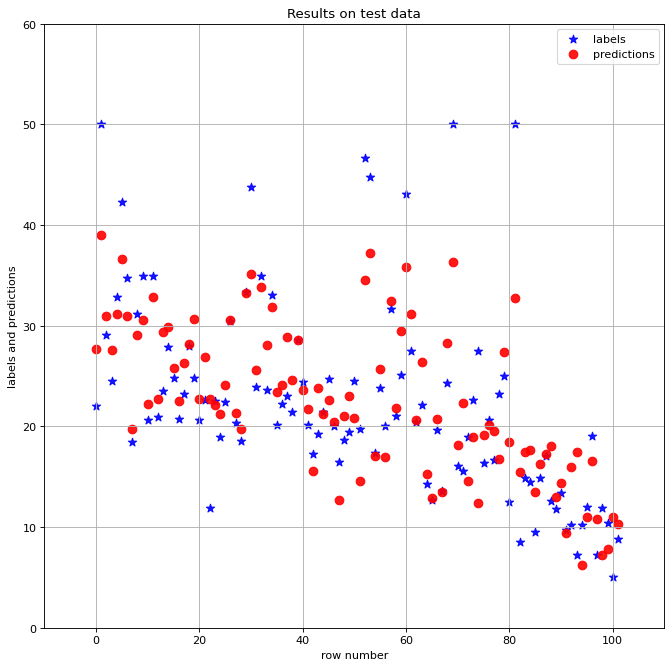

In [23]:
figure(figsize = (10, 10), dpi = 80)

plt.title('Results on test data')
plt.xlabel('row number')
plt.ylabel('labels and predictions')

x = np.arange(lr_predictions.count())
y1 = lr_predictions.select('Label').toPandas()
y2 = lr_predictions.select('prediction').toPandas()

plt.scatter(x, y1, color = 'blue', marker = '*', label = 'labels', alpha = 0.9, s = 60)
plt.scatter(x, y2, color = 'red', marker = 'o', label = 'predictions', alpha = 0.9, s = 60)

plt.xlim(-10, 110)
plt.ylim(0, 60)

plt.legend()
plt.grid()
plt.show()

### Add regularization to model
* Try different values of regularization parameters `regParam` and `elasticNetParam` to see how performance changes.
* Look into the API specification for [regParam](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html#pyspark.ml.regression.LinearRegression.regParam) and [elasticNetParam](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html#pyspark.ml.regression.LinearRegression.elasticNetParam) to get more details.

In [24]:
# Fixed maxIter = 100 and elasticNetParam = 0.0
for i in [0.0, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0]:
    lr_turn = LinearRegression(featuresCol = 'features_scaled', labelCol = 'Label', maxIter = 100, regParam = i, elasticNetParam = 0.0)
    lr_model_trun = lr_turn.fit(lr_train_df)
    trainingSummary_turn = lr_model_trun.summary
    print("regParam:", i)
    print("RMSE:", trainingSummary_turn.rootMeanSquaredError)
    print("r2:", trainingSummary_turn.r2, '\n')

regParam: 0.0
RMSE: 4.6802249769901465
r2: 0.7329316235257317 

regParam: 0.001
RMSE: 4.680225381983311
r2: 0.7329315773053589 

regParam: 0.01
RMSE: 4.680264517229217
r2: 0.7329271109255413 

regParam: 0.1
RMSE: 4.683404063344088
r2: 0.7325686829438911 

regParam: 0.5
RMSE: 4.720788605369378
r2: 0.7282821853007357 

regParam: 1.0
RMSE: 4.777102441193911
r2: 0.7217609285384217 

regParam: 2.0
RMSE: 4.887228606670016
r2: 0.7087846152530008 



In [25]:
# Fixed maxIter = 100 and regParam = 0.0
for i in [0.0, 0.25, 0.5, 0.75, 1.0]:
    lr_turn_2 = LinearRegression(featuresCol = 'features_scaled', labelCol = 'Label', maxIter = 100, regParam = 0.5 , elasticNetParam = i)
    lr_model_trun_2 = lr_turn_2.fit(lr_train_df)
    trainingSummary_turn_2 = lr_model_trun_2.summary
    print("elasticNetParam:", i)
    print("RMSE:", trainingSummary_turn_2.rootMeanSquaredError)
    print("r2:", trainingSummary_turn_2.r2, '\n')

elasticNetParam: 0.0
RMSE: 4.720788605369378
r2: 0.7282821853007357 

elasticNetParam: 0.25
RMSE: 4.802772448395353
r2: 0.7187626302680573 

elasticNetParam: 0.5
RMSE: 4.919878044376446
r2: 0.704880652991825 

elasticNetParam: 0.75
RMSE: 5.02044542932767
r2: 0.6926922534843293 

elasticNetParam: 1.0
RMSE: 5.132810679216404
r2: 0.6787822778451524 



In [26]:
print('regParam is bigger, the error rate is bigger, vice versa.')
print('elasticNetParam is bigger, the error rate is bigger, vice versa.')

regParam is bigger, the error rate is bigger, vice versa.
elasticNetParam is bigger, the error rate is bigger, vice versa.


In [27]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

lr_3 = LinearRegression(featuresCol = 'features_scaled', labelCol = 'Label')

# Create ParamGrid for Cross Validation
lrparamGrid = (ParamGridBuilder()
             .addGrid(lr_3.regParam, [0.0, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0])
             .addGrid(lr_3.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .addGrid(lr_3.maxIter, [1, 5, 10, 20, 50, 100, 200])
             .build())

lrevaluator = RegressionEvaluator(predictionCol = "prediction", labelCol = "Label", metricName = "rmse")

# Create 5-fold CrossValidator
lrcv = CrossValidator(estimator = lr_3, estimatorParamMaps = lrparamGrid, evaluator = lrevaluator, numFolds = 5)

# Run cross validations
lrcvModel = lrcv.fit(lr_test_df)
best_model = lrcvModel.bestModel

In [28]:
best_reg_param = best_model._java_obj.getRegParam()
best_elasticnet_param = best_model._java_obj.getElasticNetParam()
best_max_Iter = best_model._java_obj.getMaxIter()
print('best regParam:', best_reg_param, '\nbest elasticNetParam:', best_elasticnet_param, '\nbest max iter:', best_max_Iter)

best regParam: 0.001 
best elasticNetParam: 0.25 
best max iter: 5


In [29]:
Summary = best_model.summary
print("\nRMSE: %f" % Summary.rootMeanSquaredError)
print("r2: %f" % Summary.r2)


RMSE: 5.059304
r2: 0.727421


### Stop the spark session

In [30]:
spark.stop()